In [1]:
!pip install livelossplot split-folders wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 19.1 MB/s 
     |████████████████████████████████| 1.6 MB 58.9 MB/s 
     |████████████████████████████████| 182 kB 65.9 MB/s 
     |████████████████████████████████| 168 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 71.8 MB/s 
     |████████████████████████████████| 166 kB 75.2 MB/s 
     |████████████████████████████████| 162 kB 76.3 MB/s 
     |████████████████████████████████| 162 kB 73.0 MB/s 
     |████████████████████████████████| 158 kB 71.0 MB/s 
     |████████████████████████████████| 157 kB 69.2 MB/s 
     |████████████████████████████████| 157 kB 71.9 MB/s 
     |████████████████████████████████| 157 kB 65.9 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 157 kB 65.0 MB/s 
     |███████████████████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Bicycle_crash/
%ls

Mounted at /content/drive/
/content/drive/My Drive/Bicycle_crash
data/  saved_models/  src/  wandb/


In [5]:
import splitfolders

splitfolders.ratio("src", "data", seed=42, ratio=(.8, .2))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  6.64 files/s]
Copying files: 10 files [00:00, 15.19 files/s]
Copying files: 12 files [00:01,  6.42 files/s]
Copying files: 13 files [00:10,  1.37s/ files]
Copying files: 21 files [00:10,  1.87 files/s]
Copying files: 29 files [00:10,  3.44 files/s]
Copying files: 34 files [00:10,  4.68 files/s]
Copying files: 41 files [00:10,  7.13 files/s]
Copying files: 46 files [00:11,  9.13 files/s]
Copying files: 51 files [00:11,  9.27 files/s]
Copying files: 65 files [00:11, 18.05 files/s]
Copying files: 79 files [00:11, 28.73 files/s]
Copying files: 90 files [00:11, 37.84 files/s]
Copying files: 100 files [00:12, 45.96 files/s]
Copying files: 110 files [00:12, 54.25 files/s]
Copying files: 122 files [00:12, 65.86 files/s]
Copying files: 132 files [00:12, 72.07 files/s]
Copying files: 142 files [00:12, 77.97 files/s]
Copying files: 152 files [00:13, 25.85 files/s]
Copying files: 166 files [00:13, 36.92 files/s]
Copying fil

In [6]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import warnings
from livelossplot import PlotLosses
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.empty_cache() 
torch.cuda.get_device_name(0)

'Tesla T4'

In [9]:
SIZE = (224, 224)

transforms_train = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.RandomAffine(15),
    transforms.GaussianBlur(1),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
# train and test directories
train_dir = "data/train/"
test_dir = "data/val/"

In [11]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

# create train dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=5,
)

# create test dataloader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=5,
)

In [12]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
num_classes = len(class_names)
print('Number of classes:', num_classes)

Train dataset size: 1746
Test dataset size: 438
Number of classes: 2


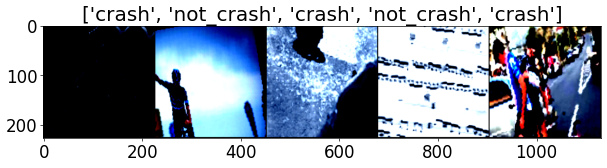

In [13]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))
    plt.imshow(input)
    plt.title(title)
    plt.show()

iterator = iter(train_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[class_names[x] for x in classes[:5]])

In [14]:
def train_model(name, model):
    
    path = f"saved_models/{name}.pth"
    
    start_time = time.time()
    wandb.init(
        project="Bicycle",
        entity="kokteubay-raiymbek",
        name=name,
        config={
            "lr": 3e-4,
            "model_name": name,
            "epochs": 10,
        }
    )
    config = wandb.config
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    model = model.to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    
    wandb.watch(model)

    for epoch in range(0, config.epochs):
    
        print(f"Epoch {epoch} running")
        model.train()
        running_loss = 0.
        running_corrects = 0 
        
        for i, (inputs, labels) in enumerate(train_dataloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 
            
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s' \
              .format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            val_epoch_loss = running_loss / len(test_dataset)
            val_epoch_acc = running_corrects / len(test_dataset) * 100.
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s' \
                  .format(epoch, val_epoch_loss, val_epoch_acc, time.time()- start_time))
            metrics = {
                "test/loss": val_epoch_loss, 
                "test/accuracy": val_epoch_acc,
                "train/loss": epoch_loss, 
                "train/accuracy": epoch_acc,
            }    
            wandb.log(metrics) 
    
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, path)

wandb.finish()

In [15]:
resnets = {
    "resnet50":  models.resnet50(pretrained=True),
    "resnet152": models.resnet152(pretrained=True),
}

for name, model in resnets.items():
    train_model(name, model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

wandb: Currently logged in as: kokteubay-raiymbek. Use `wandb login --relogin` to force relogin


Epoch 0 running
[Train #0] Loss: 0.6110 Acc: 69.2440% Time: 53.6043s
[Test #0] Loss: 0.5064 Acc: 75.1142% Time: 62.1282s
Epoch 1 running
[Train #1] Loss: 0.5194 Acc: 75.3723% Time: 111.4570s
[Test #1] Loss: 0.4395 Acc: 80.5936% Time: 120.1986s
Epoch 2 running
[Train #2] Loss: 0.4554 Acc: 78.9233% Time: 162.6821s
[Test #2] Loss: 0.5066 Acc: 77.6256% Time: 171.3509s
Epoch 3 running
[Train #3] Loss: 0.4001 Acc: 81.3288% Time: 213.3334s
[Test #3] Loss: 0.6661 Acc: 71.6895% Time: 222.1092s
Epoch 4 running
[Train #4] Loss: 0.4232 Acc: 81.9015% Time: 264.2438s
[Test #4] Loss: 0.5263 Acc: 78.9954% Time: 272.9059s
Epoch 5 running
[Train #5] Loss: 0.3596 Acc: 83.3906% Time: 315.1500s
[Test #5] Loss: 0.6560 Acc: 74.8858% Time: 323.8623s
Epoch 6 running
[Train #6] Loss: 0.3462 Acc: 85.0516% Time: 365.0393s
[Test #6] Loss: 0.4468 Acc: 80.5936% Time: 373.7514s
Epoch 7 running
[Train #7] Loss: 0.3287 Acc: 86.5979% Time: 415.2638s
[Test #7] Loss: 0.5369 Acc: 81.2785% Time: 424.0349s
Epoch 8 running
[T

test/accuracy,▄█▅▁▆▃██▇▆
test/loss,▃▁▃█▄█▁▄▆▇
train/accuracy,▁▃▅▆▆▆▇███
train/loss,█▆▅▄▄▃▂▂▂▁
test/accuracy,78.08218
test/loss,0.62695
train/accuracy,87.39977
train/loss,0.27872


Epoch 0 running
[Train #0] Loss: 0.6034 Acc: 69.2440% Time: 59.2138s
[Test #0] Loss: 1.3418 Acc: 63.9269% Time: 68.8897s
Epoch 1 running
[Train #1] Loss: 0.5228 Acc: 74.3986% Time: 134.5656s
[Test #1] Loss: 0.9359 Acc: 59.5890% Time: 144.1248s
Epoch 2 running
[Train #2] Loss: 0.5026 Acc: 75.2005% Time: 198.3861s
[Test #2] Loss: 0.5347 Acc: 78.3105% Time: 208.0162s
Epoch 3 running
[Train #3] Loss: 0.4462 Acc: 78.3505% Time: 262.9208s
[Test #3] Loss: 0.4710 Acc: 80.3653% Time: 272.3107s
Epoch 4 running
[Train #4] Loss: 0.4287 Acc: 80.4697% Time: 325.8176s
[Test #4] Loss: 0.6813 Acc: 75.1142% Time: 335.3428s
Epoch 5 running
[Train #5] Loss: 0.3987 Acc: 82.5315% Time: 389.9796s
[Test #5] Loss: 0.5151 Acc: 75.5708% Time: 399.5563s
Epoch 6 running
[Train #6] Loss: 0.3902 Acc: 82.9897% Time: 452.1417s
[Test #6] Loss: 0.8468 Acc: 69.8630% Time: 461.7677s
Epoch 7 running
[Train #7] Loss: 0.3792 Acc: 82.9324% Time: 514.8138s
[Test #7] Loss: 0.4720 Acc: 77.8539% Time: 524.3338s
Epoch 8 running
[T